# library &function

In [1]:
source('../function.r')

In [2]:
suppressPackageStartupMessages(
    {library('data.table')
    library('mvtnorm')
    library('Matrix')
    library('mixtools')
    library('parallel')}
)

In [3]:
# function of data generation
# ncells: the number of control cells
# dis: the distance between two clusters in Control
# beta: perturb effects
# prob_diff: the cluster ratio difference between control and perturb
# plot: If plot the Scatter plot of datasets

func_generate_data_2D <- function(dis_=0, prob=0.5, ncells=1000, beta=c(1,1),prob_diff=0, plot=FALSE,seed_=NULL){
    
    # the center of two clusters is (0,0) (dis,0)
    # the sd is [1,0;0,1] [0.5,0;0,0.5]
    # the cluster ratio in Control is pro, 1- prob
    # the cluster ratio in Perturb cells is pro+pro_diff, 1-(..)
    # beta is [1,1] 
    if(length(seed_)){
        set.seed(seed_)
    }
    xmus <- c(0,dis_)
    xsds <- c(1,0.5)
    ymus <- c(0,0)
    ysds <- c(1,0.5)
    beta=c(1,1)
    prob1 <- c(prob, 1-prob) # the probability of origin Y0
    prob2 <- c(prob+prob_diff, 1-(prob+prob_diff)) # the probability of control Z
    

    
    # generate Perturbed Cells: Y follows GMM and Y_mu_i = Z_mu_i + beta
    # use the probabilty of prob1
    comp2 <- sample(1:2, prob=prob1, size=ncells, replace=TRUE) 
    #set.seed(1)
    Y0 <- cbind(rnorm(n=ncells, mean=xmus[comp2], sd=xsds[comp2]),
                  rnorm(n=ncells, mean=ymus[comp2], sd=ysds[comp2]))
    
    Beta = matrix(rep(beta, each=ncells), ncol=2) 
    Y <- Y0 + Beta 
    
    # generate Control cells: Z follows GMM
    # use the probability of prob2
    comp1 <- sample(1:2, prob=prob2, size=ncells, replace=TRUE)
    #set.seed(0)
    Z <- cbind(rnorm(n=ncells, mean=xmus[comp1],sd=xsds[comp1]),
                  rnorm(n=ncells, mean=ymus[comp1],sd=ysds[comp1]))
    
    
    if(plot){
        ref.cols <- c("blue", "red")
        clust1 <- ref.cols[comp1]
        plot(Z, pch=16, cex=1.5, col=clust1,
        main=paste0("Control Cells"), xlab="PC1", ylab="PC2")

        clust2 <- ref.cols[comp2]
        plot(Y0, pch=16, cex=1.5, col=clust2,
        main="Experimental Cells", xlab = "PC1", ylab= "PC2")    
    }
    
    # export generated Z Y0 Y
    results <- list("Z"=Z, "Y0"=Y0, "Y"=Y)
    return(results)
}

In [4]:
get_error <- function(dis_=0, prob=0.5, ncells=2000, beta=c(1,1),prob_diff=0, seed_=NULL,
                      direction=NULL,plot=FALSE){
        
    results <- func_generate_data_2D(dis=dis_, prob=prob, ncells=ncells, prob_diff=prob_diff, plot=plot,seed_=seed_)
    Z <- results$Z
    Y0 <- results$Y0
    Y <- results$Y  
    Z_EM_results <- mvnormalmixEM(Z,k = 2)

    beta_mean <- col_means(Y) - col_means(Z)
    Y_EM <- get_beta_EM_sep_method(y = Y,number.component = 2,
                               em = Z_EM_results$mu, es = Z_EM_results$sigma, el = Z_EM_results$lambda, 
                               beta_init = beta_mean)
    beta_EM <- Y_EM$beta
    

    error_EM <- sqrt(sum((beta_EM - beta)^2))
    error_mean <- sqrt(sum(beta_mean - beta)^2)

    error_EM_x <- abs(beta_EM-beta)[1]
    error_mean_x <- abs(beta_mean-beta)[1]
    error_EM_y <- abs(beta_EM-beta)[2]
    error_mean_y <- abs(beta_mean-beta)[2]

    #return(list(beta_EM,beta_mean,beta))
    return(list(error_EM=error_EM,error_mean=error_mean,
                error_EM_x=error_EM_x,error_mean_x=error_mean_x,
               error_EM_y=error_EM_y,error_mean_y=error_mean_y,
               data=results))
    
}

# Generate Data

## change the distance

### 2-D error

In [5]:
results_all <- c()
seed_list.dis <- c()
for(dis in seq(0,4,0.5)){
    seeds <- sample(1:1e6,100)
    results <- mclapply(1:100,function(x){get_error(dis,prob=0.5,prob_diff=0.1,seed_ = seeds[x])})
    results_all[[as.character(dis)]] <- results
    seed_list.dis[[as.character(dis)]] <- seeds                       
}


Warning message in mclapply(1:100, function(x) {:
“all scheduled cores encountered errors in user code”
Warning message in mclapply(1:100, function(x) {:
“all scheduled cores encountered errors in user code”
Warning message in mclapply(1:100, function(x) {:
“all scheduled cores encountered errors in user code”
Warning message in mclapply(1:100, function(x) {:
“all scheduled cores encountered errors in user code”


In [8]:
data.dis <- results_all%>%lapply(function(x){x%>%lapply(function(y){y[[7]]})})

In [9]:
df <- c()
for(i in 1:6){
    df <- rbind(df,results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist%>%mean}),
                    results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist%>%sd}))
}

In [10]:
#colnames(df) <- c(0:10)

rownames(df) <- c('fc.mean','fc.sd','em.mean','em.sd',
                 'fc_D1.mean','fc_D1.sd','em_D1.mean','em_D1.sd',
                 'fc_D2.mean','fc_D2.sd','em_D2.mean','em_D2.sd')

df <- apply(df,c(1,2),as.numeric)


In [11]:
df_long <- c()

for(i in c(1,3,5)){
    df_long <- df_long%>%bind_rows(results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist})%>%
            as.data.frame%>%mutate(method='em',dimension=round((i-1)/2))%>%pivot_longer(cols = 1:(ncol(.)-2)),
              results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i+1]]})%>%unlist})%>%
            as.data.frame%>%mutate(method='fc',dimension=round((i-1)/2))%>%pivot_longer(cols = 1:(ncol(.)-2)))
    
}

df_long$value <- as.numeric(df_long$value)

df_long$name <- factor(df_long$name,levels=paste0('X',results_all%>%ls))

df_long_dis <- df_long

## change the ratio

### the distance fix as 3
### fix the ratio of Y0 as 0.5
### change the ratio of Z: the difference from 0 to 0.45, step 0.05 

In [ ]:
results_all <- c()
seed_list.ratio <- c()
for(pro_diff in seq(0,0.4,0.02)){
    seeds <- sample(1:1e6,100)
    results <- mclapply(1:100,function(x)(get_error(dis_=3,prob=0.5,prob_diff=pro_diff)))
    results_all[[as.character(pro_diff)]] <- results
    seed_list.ratio[[as.character(dis)]] <- seeds 
                        
}


In [ ]:
data.ratio <- results_all%>%lapply(function(x){x%>%lapply(function(y){y[[7]]})})

In [ ]:
df <- c()
for(i in 1:6){
    df <- rbind(df,results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist%>%mean}),
                    results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist%>%sd}))
}

In [ ]:
#colnames(df) <- c(0:10)

rownames(df) <- c('fc.mean','fc.sd','em.mean','em.sd',
                 'fc_D1.mean','fc_D1.sd','em_D1.mean','em_D1.sd',
                 'fc_D2.mean','fc_D2.sd','em_D2.mean','em_D2.sd')

df <- apply(df,c(1,2),as.numeric)


In [50]:
df_long <- c()

for(i in c(1,3,5)){
    df_long <- df_long%>%bind_rows(results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist})%>%
            as.data.frame%>%mutate(method='em',dimension=round((i-1)/2))%>%pivot_longer(cols = 1:(ncol(.)-2)),
              results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i+1]]})%>%unlist})%>%
            as.data.frame%>%mutate(method='fc',dimension=round((i-1)/2))%>%pivot_longer(cols = 1:(ncol(.)-2)))
    
}

df_long$value <- as.numeric(df_long$value)

df_long$name <- factor(df_long$name,levels=paste0('X',seq(0,0.4,0.02)))

df_long_ratio <- df_long

# change cluster reponse, differ the reponse of each cluster

In [6]:
func_generate_data_2D_diffBeta <- function(dis_=0, prob=0.5, ncells=1000, beta1=c(1,1),beta_diff=0, prob_diff=0, plot=FALSE,seed_=NULL){

    if(length(seed_)){
        set.seed(seed_)
    }
    xmus <- c(0,dis_)
    xsds <- c(1,0.5)
    ymus <- c(0,0)
    ysds <- c(1,0.5)
    beta=c(1,1)
    prob1 <- c(prob, 1-prob) # the probability of control Z
    prob2 <- c(prob+prob_diff, 1-(prob+prob_diff)) # the probability of origin Y0
    

    
    # generate Perturbed Cells: Y follows GMM and Y_mu_i = Z_mu_i + beta
    # use the probabilty of prob1
    comp2 <- sample(1:2, prob=prob1, size=ncells, replace=TRUE) 
    #set.seed(1)
    Y0 <- cbind(rnorm(n=ncells, mean=xmus[comp2], sd=xsds[comp2]),
                  rnorm(n=ncells, mean=ymus[comp2], sd=ysds[comp2]))
    
    Beta = matrix(rep(beta, each=ncells), ncol=2) 
    Beta[which(comp2==2),1] <- beta[1]+beta_diff
    
    Y <- Y0 + Beta 
    
    # generate Control cells: Z follows GMM
    # use the probability of prob2
    comp1 <- sample(1:2, prob=prob2, size=ncells, replace=TRUE)
    Z <- cbind(rnorm(n=ncells, mean=xmus[comp1],sd=xsds[comp1]),
                  rnorm(n=ncells, mean=ymus[comp1],sd=ysds[comp1]))
    # export generated Z Y0 Y
    results <- list("Z"=Z, "Y0"=Y0, "Y"=Y,'Beta'=Beta,'comp'=comp2)
    return(results)
}

In [7]:
# dis_=3;prob=0.5;ncells=2000;beta=c(1,1);prob_diff=0;beta_diff=0;seed_=NULL;direction=NULL;plot=FALSE
get_error_diffBeta <- function(dis_=0, prob=0.5, ncells=2000, beta=c(1,1),
                               prob_diff=0,beta_diff=0, seed_=NULL,
                              direction=NULL,plot=FALSE,fix_es=FALSE){
        
    results <- func_generate_data_2D_diffBeta(dis=dis_, prob=prob, ncells=ncells, 
                                              prob_diff=prob_diff,beta_diff=beta_diff,
                                              plot=plot,seed_=seed_)
    Z <- results$Z
    Y0 <- results$Y0
    Y <- results$Y  
    Z_EM_results <- mvnormalmixEM(Z,k = 2)

    beta_mean <- col_means(Y) - col_means(Z)
    Y_EM <- get_beta_EM_sep_method(y = Y,number.component = 2,fix_es=fix_es,
                               em = Z_EM_results$mu, es = Z_EM_results$sigma, el = Z_EM_results$lambda, 
                               beta_init = beta_mean)
    beta_EM <- Y_EM$beta
    
    # set the cluster ID, make it the same as component
    if(Z_EM_results$mu[[2]][1] < Z_EM_results$mu[[1]][1]){
        labels <- (results$comp)-1
        labels[which(labels==0)] <- 2
    }else{
        labels <- (results$comp)
    }
    
    error_EM <- sqrt(sum((beta_EM - beta)^2))
    error_mean <- sqrt(sum(beta_mean - beta)^2)

    error_EM_x <- abs(beta_EM-beta)[1]
    error_mean_x <- abs(beta_mean-beta)[1]
    error_EM_y <- abs(beta_EM-beta)[2]
    error_mean_y <- abs(beta_mean-beta)[2]
    accuracy <- sum(labels == Y_EM$ey%>%apply(1,function(x){which.max(x)}))/ncells


    return(list(error_EM=error_EM,error_mean=error_mean,
                error_EM_x=error_EM_x,error_mean_x=error_mean_x,
               error_EM_y=error_EM_y,error_mean_y=error_mean_y,
                accuracy=accuracy,
               data=results))
    
}

# simulations

In [8]:
results_all <- c()
seed_list.ratio <- c()
for(beta_diff in seq(-8,4)){
    seeds <- sample(1:1e6,100)
    results <- mclapply(1:100,function(x)(get_error_diffBeta(dis_=3,prob=0.5,prob_diff=0.1,
                                                             beta_diff=beta_diff)))
    results_all[[as.character(beta_diff)]] <- results
    seed_list.ratio[[as.character(beta_diff)]] <- seeds 
                        
}


In [9]:
accuracy <- results_all%>%lapply(function(x){x%>%lapply(function(y){y[[7]]})})

data.beta <- results_all%>%lapply(function(x){x%>%lapply(function(y){y[[8]]})})

In [13]:
df <- c()
for(i in 1:6){
    df <- rbind(df,results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist%>%mean}),
                    results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist%>%sd}))
}

In [14]:
#colnames(df) <- c(0:10)

rownames(df) <- c('fc.mean','fc.sd','em.mean','em.sd',
                 'fc_D1.mean','fc_D1.sd','em_D1.mean','em_D1.sd',
                 'fc_D2.mean','fc_D2.sd','em_D2.mean','em_D2.sd')

df <- apply(df,c(1,2),as.numeric)


In [30]:
df_long <- c()

for(i in c(1,3,5)){
    df_long <- df_long%>%bind_rows(results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i]]})%>%unlist})%>%
            as.data.frame%>%mutate(method='em',dimension=round((i-1)/2))%>%pivot_longer(cols = 1:(ncol(.)-2)),
              results_all%>%lapply(function(x){x%>%lapply(function(y){y[[i+1]]})%>%unlist})%>%
            as.data.frame%>%mutate(method='fc',dimension=round((i-1)/2))%>%pivot_longer(cols = 1:(ncol(.)-2)))
    
}

df_long$value <- as.numeric(df_long$value)

In [31]:
df_long$name <- factor(df_long$name %>% gsub('X\\.','X-',.),levels=paste0('X',c((-8):4)))

df_long_ratio <- df_long

# plot Results

In [4]:
library('ggpubr')

In [5]:
colors_ <- RColorBrewer::brewer.pal(name = "Blues", n = 5)
plot_errorBox <- function(df,xlab_,ylab_='L2 Loss',ylim_=c(0,0.7),outlier_size=0.1,title_=''){
    
    names=df$name%>%unique%>%as.character%>%gsub('X','',.)
    names[c(2,4,6,8)] <- ''
    
    p <- ggplot(df,aes(x=name,y=value,fill=method))+
        geom_boxplot(width=0.4,outlier.size = outlier_size,lwd=0.2)+
        #scale_x_continuous(breaks = c(1:5))+
        scale_fill_manual(values=colors_[c(3,2)]) + 
        scale_x_discrete(breaks=df$name%>%unique%>%as.character,
                         labels=names)+
        xlab(xlab_) + ylab(ylab_)+ 
        ylim(ylim_)+
        ggtitle(title_)+
        theme_classic() +
        theme(aspect.ratio = 1,
              legend.position = c(0.3,0.9),
              legend.key.size=unit(0.1,'cm'),
              legend.title=element_text(size=8,color = 'black'),
              legend.text=element_text(size=6,color = 'black'),
            axis.text.x = element_text(size = 8,color = 'black'),
            axis.title.x = element_text(size = 8, face = "bold"),
            axis.text.y = element_text(size = 8,color = 'black'),
            axis.title.y = element_text(size = 8, face = "bold"))
    return(p)
}

In [6]:
df_long <- readRDS('data/simulation.differentRatio.splitDim.v4.rds')
df_long$method <- df_long$method%>%gsub('em','scDecouple',.)%>%gsub('fc','FC',.)

df_long <- df_long%>%filter(name%in%c(paste0('X',seq(0,0.16,0.02)%>%as.character)))
plot_ratio <- plot_errorBox(df_long%>%filter(!name%in%c('X0.45'))%>%filter(dimension==0),
                            xlab_ = (paste('RatioChanges r')),title_='')
plot_ratio1 <- plot_errorBox(df_long%>%filter(!name%in%c('X0.45'))%>%filter(dimension==1),
                             xlab_ = (paste('RatioChanges r')),title_='')
plot_ratio2 <- plot_errorBox(df_long%>%filter(!name%in%c('X0.45'))%>%filter(dimension==2),
                             xlab_ = (paste('RatioChanges r')),title_='')

Warning message in gzfile(file, "rb"):
“cannot open compressed file 'data/simulation.differentRatio.splitDim.v4.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [ ]:
df_long <- readRDS('data/simulation.differentDis_splitDim.v3.rds')
df_long$method <- df_long$method%>%gsub('em','scDecouple',.)%>%gsub('fc','FC',.)

plot_dis <- plot_errorBox(df_long%>%filter(dimension==0),
                          xlab_ = (paste('Cluster Distance d')),ylim_ = c(0,0.7),title_='')
plot_dis1 <- plot_errorBox(df_long%>%filter(!name%in%c('X8','X9','X10'))%>%filter(dimension==1),
                           xlab_ = (paste('Cluster Distance d')),ylim_ = c(0,0.7),title_='')
plot_dis2 <- plot_errorBox(df_long%>%filter(!name%in%c('X8','X9','X10'))%>%filter(dimension==2),
                           xlab_ = (paste('Cluster Distance d')),ylim_ = c(0,0.7),title_='')

In [ ]:
df_long <- readRDS('data/simulation.differentBeta.splitDim.v4.rds')
df_long$method <- df_long$method%>%gsub('em','scDecouple',.)%>%gsub('fc','FC',.)

In [77]:
#df_long <- df_long%>%filter(name%in%c(paste0('X',seq(0,0.16,0.02)%>%as.character)))
plot_beta <- plot_errorBox(df_long%>%filter(dimension==0),ylim_=c(0,3),
                            xlab_ = 'BetaChanges',title_='Loss by RatioChanges')
plot_beta1 <- plot_errorBox(df_long%>%filter(dimension==1),ylim_=c(0,3),
                             xlab_ = 'BetaChanges',title_='Loss by RatioChanges on Dim1')
plot_beta2 <- plot_errorBox(df_long%>%filter(dimension==2),
                             xlab_ = 'BetaChanges',title_='Loss by RatioChanges on Dim2')

# plot data

In [78]:
# saveRDS(data.ratio,'simulation.differentRatio.data.v2.rds')
# saveRDS(data.dis,'simulation.differentDis.data.v2.rds')

In [79]:
# data=data.ratio;dim_=c(1);statistics_='p.value';xlab_='';ylab_='p.value';ylim_=c(0,1);title_=''
plot_diptest <- function(data,dim_=c(1,2),statistics_='p.value',outlier_size=0.1,
                         xlab_,ylab_='p.value',ylim_=c(0,1),title_=''){
    library(diptest)
    df.dip <- data%>%lapply(function(x){
        x%>%lapply(function(x){
            (x$Z)[,dim_]%>%dip.test%>%.[[statistics_]]
        })%>%unlist
    })
    df.dip <- df.dip%>%as.data.frame%>%pivot_longer(1:ncol(.))
    if(statistics_=='statistic'){
        df.dip$value <- 100*df.dip$value
    }
    
    names=df.dip$name%>%unique%>%as.character%>%gsub('X','',.)
    names[c(2,4,6,8)] <- ''
    
    #df.dip$name <- as.numeric(gsub('X','',df.dip$name))
    p <- ggplot(df.dip,aes(x=name,y=value))+
        geom_boxplot(aes(group=name),width=0.2,outlier.size = outlier_size,lwd=0.2)+
        #geom_smooth()+
        #scale_fill_manual(values=colors_[c(3,2)]) + 
        scale_x_discrete(breaks=df.dip$name%>%unique%>%as.character,
                         labels=names)+
        xlab(xlab_) + ylab(ylab_)+ 
        ylim(ylim_)+
        ggtitle(title_)+
        theme_classic() +
        theme(aspect.ratio = 1, 
            axis.text.x = element_text(size = 8,color = 'black'),
            axis.title.x = element_text(size = 8,color = 'black', face = "bold"),
            axis.text.y = element_text(size = 8,color = 'black'),
            axis.title.y = element_text(size = 8,color = 'black', face = "bold"))
    return(p)
}

In [80]:
dim_ = c(1,2)
statistics_='statistic'
df.dip <- data.dis%>%lapply(function(x){
        x%>%lapply(function(x){
            (x$Z)[,dim_]%>%dip.test%>%.[[statistics_]]
        })%>%unlist
    })
    df.dip <- df.dip%>%as.data.frame%>%pivot_longer(1:ncol(.))

In [83]:
diptest_D1_p <- plot_diptest(data.dis,dim_=c(1),statistics_='p.value', 
                             xlab_ = (paste('Cluster Distance d')),title_='')
diptest_D1_dip <- plot_diptest(data.dis,
                           dim_=c(1),statistics_='statistic', 
                               xlab_ = (paste('Cluster Distance d')),ylab_='Multimodality',ylim=c(0,10),title_='')
diptest_D2_p <- plot_diptest(data.dis,
                            dim_=c(2),statistics_='p.value',
                             xlab_ = (paste('Cluster Distance d')),title_='')
diptest_D2_dip <- plot_diptest(data.dis,
                           dim_=c(2),statistics_='statistic',
                               xlab_ = (paste('Cluster Distance d')),ylab_='Multimodality',ylim=c(0,10),title_='')

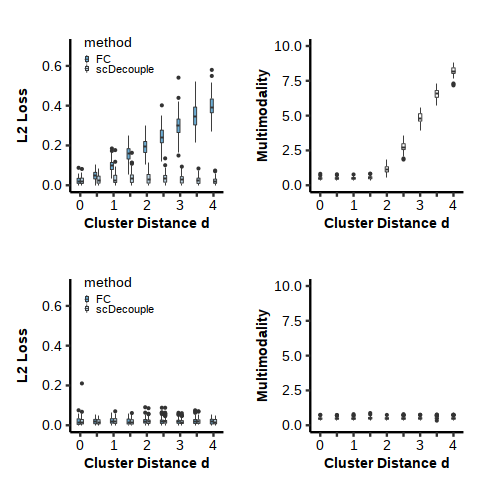

In [84]:
psize(4,4)
ggarrange(plot_dis1, diptest_D1_dip,
          plot_dis2, diptest_D2_dip,
          #labels = c("A", "",'','B','','',''),
          ncol = 2, nrow=2,
          align = "hv")#+theme(aspect.ratio = 0.4)
ggsave('plots/simulation_splitDim_distance_v5.pdf',height = 4,width = 4)

In [85]:
data.ratio.sub <- data.ratio[1:9]

In [88]:
diptest_D1_p <- plot_diptest(data.ratio.sub,dim_=c(1),statistics_='p.value', 
                             xlab_ = (paste('RatioChanges r')),title_='')
diptest_D1_dip <- plot_diptest(data.ratio.sub,
                           dim_=c(1),statistics_='statistic', 
                               xlab_ = (paste('RatioChanges r')),ylab_='Multimodality',ylim=c(0,6),title_='')
diptest_D2_p <- plot_diptest(data.ratio.sub,
                            dim_=c(2),statistics_='p.value',
                             xlab_ = (paste('RatioChanges r')),title_='')
diptest_D2_dip <- plot_diptest(data.ratio.sub,
                           dim_=c(2),statistics_='statistic',
                               xlab_ = (paste('RatioChanges r')),ylab_='Multimodality',ylim=c(0,6),title_='')

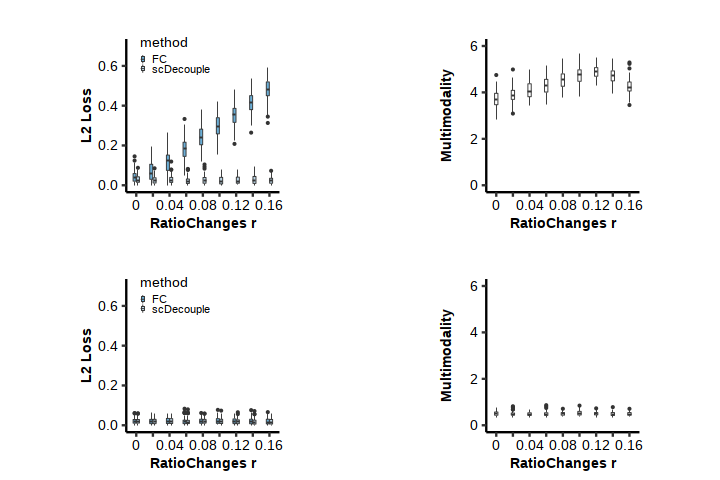

In [89]:
psize(6,4)
ggarrange(plot_ratio1, diptest_D1_dip,
          plot_ratio2, diptest_D2_dip,
          #labels = c("A", "",'','B','','',''),
          ncol = 2, nrow=2,
          align = "hv")#+theme(aspect.ratio = 0.4)
ggsave('plots/simulation_splitDim_ratio_v5.pdf',height = 4,width = 4)